In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pykalman import KalmanFilter

np.random.seed(42)

In [2]:
file_path = '/Users/annapham/Downloads/FilteredDailyMood_anonymized.xlsx'

In [3]:
df = pd.read_excel(file_path)

In [4]:
patient_df = df[df['user_name'] == 'a']

In [5]:
rating_cols = [
    "depressedMood",
    "fatigue",
    "fidgeting",
    "increasedEnergy",
    "rapidSpeech",
    "irritability"
]

patient_data = patient_df[rating_cols]

In [6]:
# Convert the patient_data DataFrame to a NumPy array
M = patient_data.to_numpy()
print("Shape of array M:", M.shape)

Shape of array M: (42, 6)


In [7]:
# Convert NaNs to masked values
M_masked = np.ma.masked_invalid(M) 

T, obs_dim = M.shape
latent_dim = 2

In [8]:
# Initial model parameters 
latent_dim = 2
obs_dim = 6

F0 = np.array([[0.5, 0.0],   # B
               [0.0, 0.5]])

H0 = np.array([[1.0, 0.0],   # A
               [1.0, 0.0],
               [1.0, 0.0],
               [0.0, 1.0],
               [0.0, 1.0],
               [0.5, 0.5]])

Q0 = 0.01 * np.eye(latent_dim)  # Gamma
R0 = 0.1  * np.eye(obs_dim)     # Sigma
x0 = np.zeros(latent_dim) #starting guess for latent state
P0 = np.eye(latent_dim)

h0 = np.zeros(latent_dim)  # starting guess for h

In [9]:
# Kalman Filter setup
kf = KalmanFilter(
    transition_matrices=F0,
    observation_matrices=H0,
    transition_covariance=Q0,
    observation_covariance=R0,
    transition_offsets=h0,
    initial_state_mean=x0,
    initial_state_covariance=P0,
    em_vars=[
        'transition_matrices',
        'transition_offsets',
        'transition_covariance',
        'observation_covariance',
        'initial_state_mean'
    ]
)

In [10]:
# EM loop 
max_iter = 200
tol = 1e-3
loglikelihoods = []
prev_ll = -np.inf

for i in range(max_iter):
    kf = kf.em(M_masked, n_iter=1)
    ll = kf.loglikelihood(M_masked)
    loglikelihoods.append(ll)

    if abs(ll - prev_ll) < tol:
        print(f"Converged at iteration {i+1})")
        break
    prev_ll = ll
else:
    print("Did not converge within given iterations.")


Did not converge within given iterations.


In [11]:
# Estimation
U_filt, _ = kf.filter(M_masked)
U_smooth, _ = kf.smooth(M_masked)

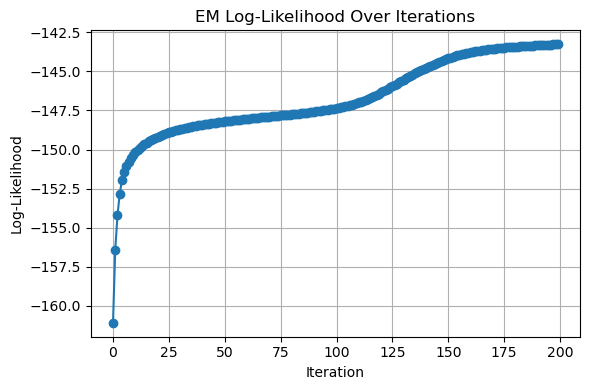

In [12]:
# Plot log-likelihood 
plt.figure(figsize=(6, 4))
plt.plot(loglikelihoods, marker='o')
plt.title("EM Log-Likelihood Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

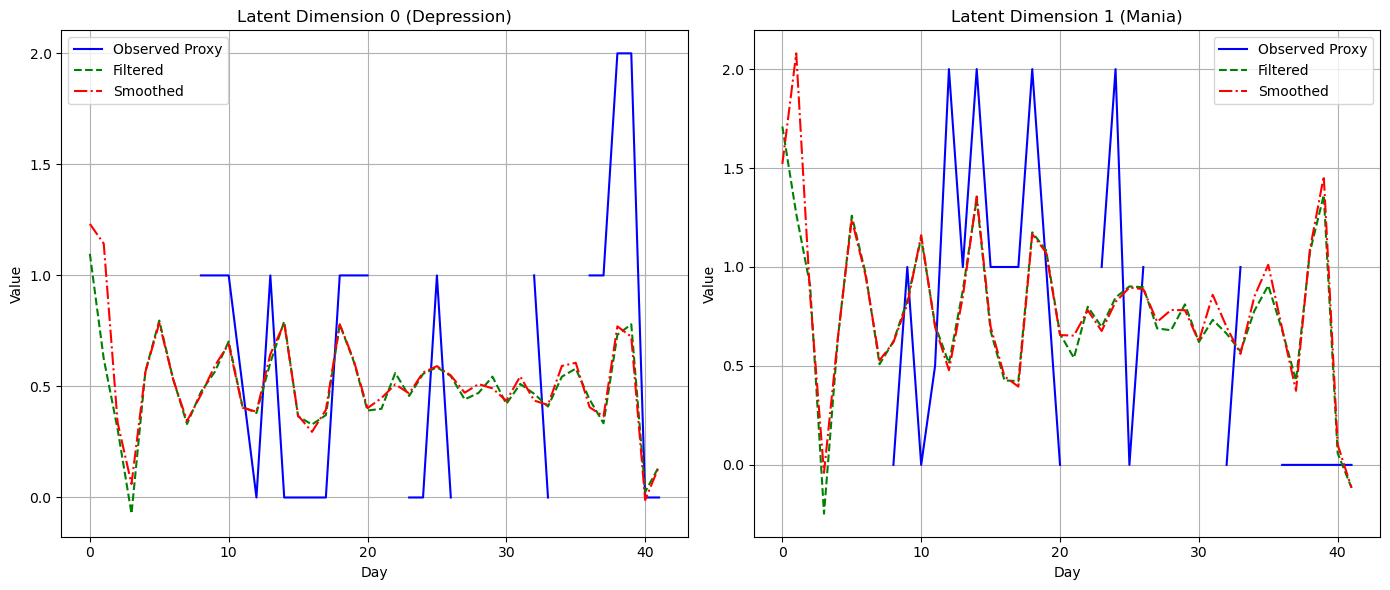

In [13]:
# Plot latent states 
proxy = {
    0: M[:, 0],  # depressedMood
    1: M[:, 3],  # increasedEnergy
}
labels = {0: "Depression", 1: "Mania"}

plt.figure(figsize=(14, 6))
for d in range(latent_dim):
    plt.subplot(1, 2, d+1)
    plt.plot(proxy[d], 'b-', label="Observed Proxy")
    plt.plot(U_filt[:, d], 'g--', label="Filtered")
    plt.plot(U_smooth[:, d], 'r-.', label="Smoothed")
    plt.title(f"Latent Dimension {d} ({labels[d]})")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Print learned parameters (rounded)
print("\n=== Learned Parameters ===")

print("A:\n", np.round(kf.observation_matrices, 2))
print("B:\n", np.round(kf.transition_matrices, 2))
print("Sigma:\n", np.round(kf.observation_covariance, 2))
print("Gamma:\n", np.round(kf.transition_covariance, 2))
print("U[0]:\n", np.round(U_smooth[0],2))
print("h: (transition_offsets):\n", np.round(kf.transition_offsets, 2))


=== Learned Parameters ===
A:
 [[1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.5 0.5]]
B:
 [[ 2.11 -1.21]
 [ 3.85 -1.9 ]]
Sigma:
 [[ 0.3   0.05 -0.09 -0.27 -0.32 -0.07]
 [ 0.05  0.4  -0.06 -0.17 -0.27 -0.04]
 [-0.09 -0.06  0.3   0.05  0.16  0.15]
 [-0.27 -0.17  0.05  0.5   0.3  -0.02]
 [-0.32 -0.27  0.16  0.3   0.56  0.03]
 [-0.07 -0.04  0.15 -0.02  0.03  0.27]]
Gamma:
 [[0.01 0.01]
 [0.01 0.03]]
U[0]:
 [1.23 1.52]
h: (transition_offsets):
 [0.37 0.29]


In [15]:
B = kf.transition_matrices
h = kf.transition_offsets

# Eigenvalues for stability analysis
eigvals, eigvecs = np.linalg.eig(B)
print("Eigenvalues:", eigvals)
print("Magnitudes:", np.abs(eigvals))

Eigenvalues: [0.1066214+0.79168794j 0.1066214-0.79168794j]
Magnitudes: [0.79883535 0.79883535]


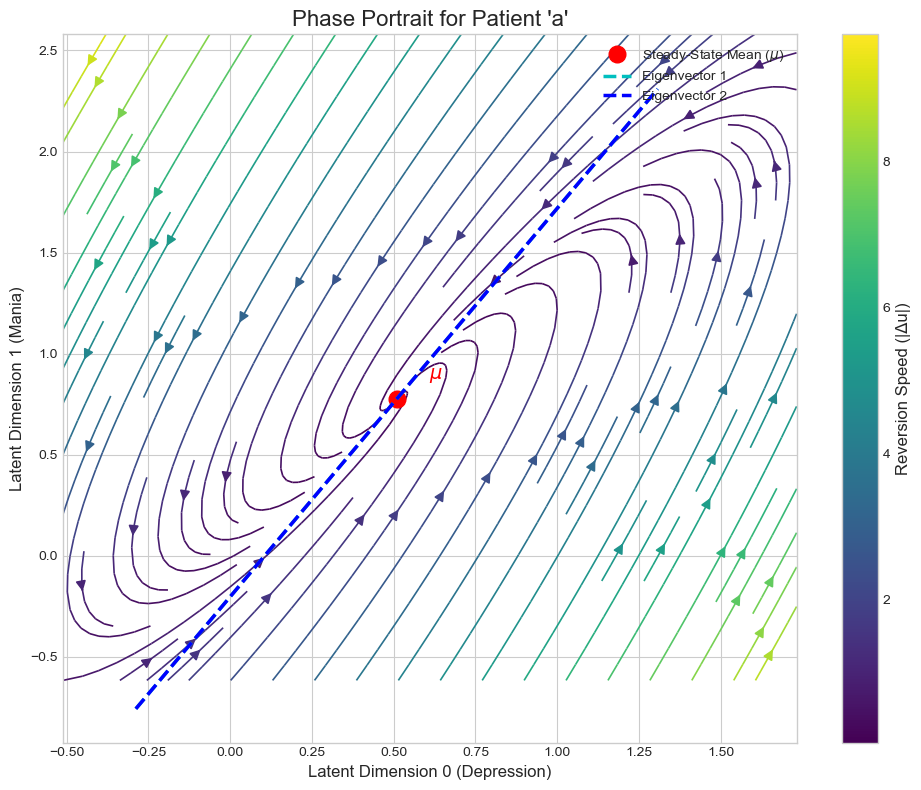

In [16]:
import matplotlib.pyplot as plt
import numpy as np

labels = {0: 'Depression', 1: 'Mania'}

# Calculate Steady-State Mean
I = np.identity(B.shape[0])
try:
    mu = np.linalg.inv(I - B) @ h
except np.linalg.LinAlgError:
    print("Cannot compute steady-state mean. The matrix (I - B) is not invertible.")
    mu = None

# Phase Portrait with colorbar
if mu is not None:
    # Create a grid of points for the streamplot
    x_min, x_max = U_smooth[:, 0].min(), U_smooth[:, 0].max()
    y_min, y_max = U_smooth[:, 1].min(), U_smooth[:, 1].max()
    x_range = np.linspace(x_min - 0.5, x_max + 0.5, 40)
    y_range = np.linspace(y_min - 0.5, y_max + 0.5, 40)
    X, Y = np.meshgrid(x_range, y_range)

    # Δu = (B - I)u + h
    U_grid = np.array([X.ravel(), Y.ravel()])
    U_change = (B - I) @ U_grid + h[:, np.newaxis]
    U_change_x = U_change[0, :].reshape(X.shape)
    U_change_y = U_change[1, :].reshape(Y.shape)
    U_change_magnitude = np.sqrt(U_change_x**2 + U_change_y**2)

    plt.figure(figsize=(10, 8))
    plt.style.use('seaborn-v0_8-whitegrid')

    strm = plt.streamplot(
        X, Y, U_change_x, U_change_y, 
        density=1.2,
        color=U_change_magnitude,
        cmap='viridis',
        linewidth=1.2,
        arrowsize=1.5
    )

    # Add colorbar for reversion speed
    cbar = plt.colorbar(strm.lines)
    cbar.set_label("Reversion Speed (|Δu|)", fontsize=12)

    # Steady-state mean
    plt.plot(mu[0], mu[1], 'ro', markersize=12, label=r'Steady-State Mean ($\mu$)')
    plt.annotate(r'$\mu$', xy=(mu[0], mu[1]),
                 xytext=(mu[0] + 0.1, mu[1] + 0.1),
                 fontsize=14, color='red')

    # Eigenvectors
    eigvals, eigvecs = np.linalg.eig(B)
    v1_real = eigvecs[:, 0].real
    v2_real = eigvecs[:, 1].real
    scale_factor = max(x_max - x_min, y_max - y_min) * 0.8
    plt.plot([mu[0] - scale_factor * v1_real[0], mu[0] + scale_factor * v1_real[0]], 
             [mu[1] - scale_factor * v1_real[1], mu[1] + scale_factor * v1_real[1]], 
             'c--', linewidth=2.5, label='Eigenvector 1')
    plt.plot([mu[0] - scale_factor * v2_real[0], mu[0] + scale_factor * v2_real[0]], 
             [mu[1] - scale_factor * v2_real[1], mu[1] + scale_factor * v2_real[1]], 
             'b--', linewidth=2.5, label='Eigenvector 2')

    plt.title("Phase Portrait for Patient 'a'", fontsize=16)
    plt.xlabel(f"Latent Dimension 0 ({labels.get(0, 'Depression')})", fontsize=12)
    plt.ylabel(f"Latent Dimension 1 ({labels.get(1, 'Mania')})", fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.savefig('Phase_portrait_one_patient.png', dpi=300)
    plt.show()
